<a href="https://colab.research.google.com/github/FelipeFerAl/SignalsTheory/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [ ]:
from IPython.display import clear_output
from sklearn.cluster import KMeans
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pickle
import zipfile
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Funciones

In [ ]:
def carga():
  folder = '/content/drive/MyDrive/BaseDatos.zip'
  with zipfile.ZipFile(folder,'r') as zip_ref:
    zip_ref.extractall('/content/BaseDatos')

In [ ]:
def add_noise(signal, snr_db):
    snr_linear = 10**(snr_db / 10.0)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
    return signal + noise

# Función para generar diferentes modulaciones
def modulate_psk(M, num_symbols):
    symbols = np.arange(M)
    angles = 2 * np.pi * symbols / M
    signal = np.exp(1j * angles)
    indices = np.random.randint(0, M, num_symbols)
    return signal[indices]

def modulate_qam(M, num_symbols):
    m = int(np.sqrt(M))
    real = np.repeat(np.arange(-m+1, m, 2), m)
    imag = np.tile(np.arange(-m+1, m, 2), m)
    signal = real + 1j * imag
    indices = np.random.randint(0, M, num_symbols)
    return signal[indices]

In [ ]:
def quad(label):
  # Initialize lists to store the mean radius for each SNR
  mean_radii = []
  snr_values = []

  # Percentage of points to be included in the circle
  percentile = 90
  num_symbols = 1000
  plt.figure(figsize=(16, 15))
  for i, snr in enumerate(snr_levels[:20]):
      plt.subplot(5, 4, i+1)

      # Signal
      if(label=='QPSK'):
        mod_sig = modulate_psk(4, 1000)
        centroid = 4
      elif(label=='QAM16'):
        mod_sig = modulate_qam(16, 1000)
        centroid = 16
      elif(label=='QAM64'):
        mod_sig = modulate_qam(64, 1000)
        centroid = 64
      elif(label=='BPSK'):
        mod_sig = modulate_psk(2, 1000)
        centroid = 2
      elif(label=='8PSK'):
        mod_sig = modulate_psk(8, 1000)
        centroid = 8

      noisy_sig = add_noise(mod_sig, snr)

      # Reshape noisy signal to have both real and imaginary components
      noisy_sig_reshaped = np.column_stack((noisy_sig.real, noisy_sig.imag))

      # Centroids
      k_means = KMeans(n_clusters=centroid)
      k_means.fit(noisy_sig_reshaped)
      centroids = k_means.cluster_centers_
      labels = k_means.labels_

      # Store the radii for each cluster
      cluster_radii = []

      # Loop over each cluster to calculate the radius
      for cluster in range(centroids.shape[0]):
        # Get the points assigned to the current cluster
        points_in_cluster = noisy_sig_reshaped[labels == cluster]

        # Calculate the distances from the points to the centroid
        distances = np.linalg.norm(points_in_cluster - centroids[cluster], axis=1)

        # Sort distances and get the distance at the 90th percentile
        radius_90_percentile = np.percentile(distances, percentile)
        cluster_radii.append(radius_90_percentile)

      # Calculate the mean radius across all clusters for the current SNR
      mean_radius = np.mean(cluster_radii)
      mean_radii.append(mean_radius)

      # Store the SNR value
      snr_values.append(snr)

      # Plot each cluster with different colors
      for i in range(0,centroid):
        plt.scatter(noisy_sig_reshaped[labels == i, 0], noisy_sig_reshaped[labels == i, 1], label=f'Cluster {i}')

      # Plot centroids
      plt.scatter(centroids[:, 0], centroids[:, 1], color='magenta', marker='o', s=64)

      # Graph configuration
      plt.title(f'{label} - SNR {snr} dB')
      plt.xlabel('In-phase')
      plt.ylabel('Quadrature')
      plt.grid(True)

  plt.tight_layout()
  plt.show()
  return np.array(mean_radii), np.array(snr_values)

#Código

In [ ]:
carga()

In [ ]:
file = '/content/BaseDatos/RML2016.10a_dict.dat'
try:
  with open(file,'rb') as f:
    data = pickle.load(f,encoding='latin1')
except:
  print('Error')

In [ ]:
# Extract modulation forms from the dictionary keys
modulation_forms = list({key[0] for key in data.keys()})
snr_levels = sorted(list({key[1] for key in data.keys()}))

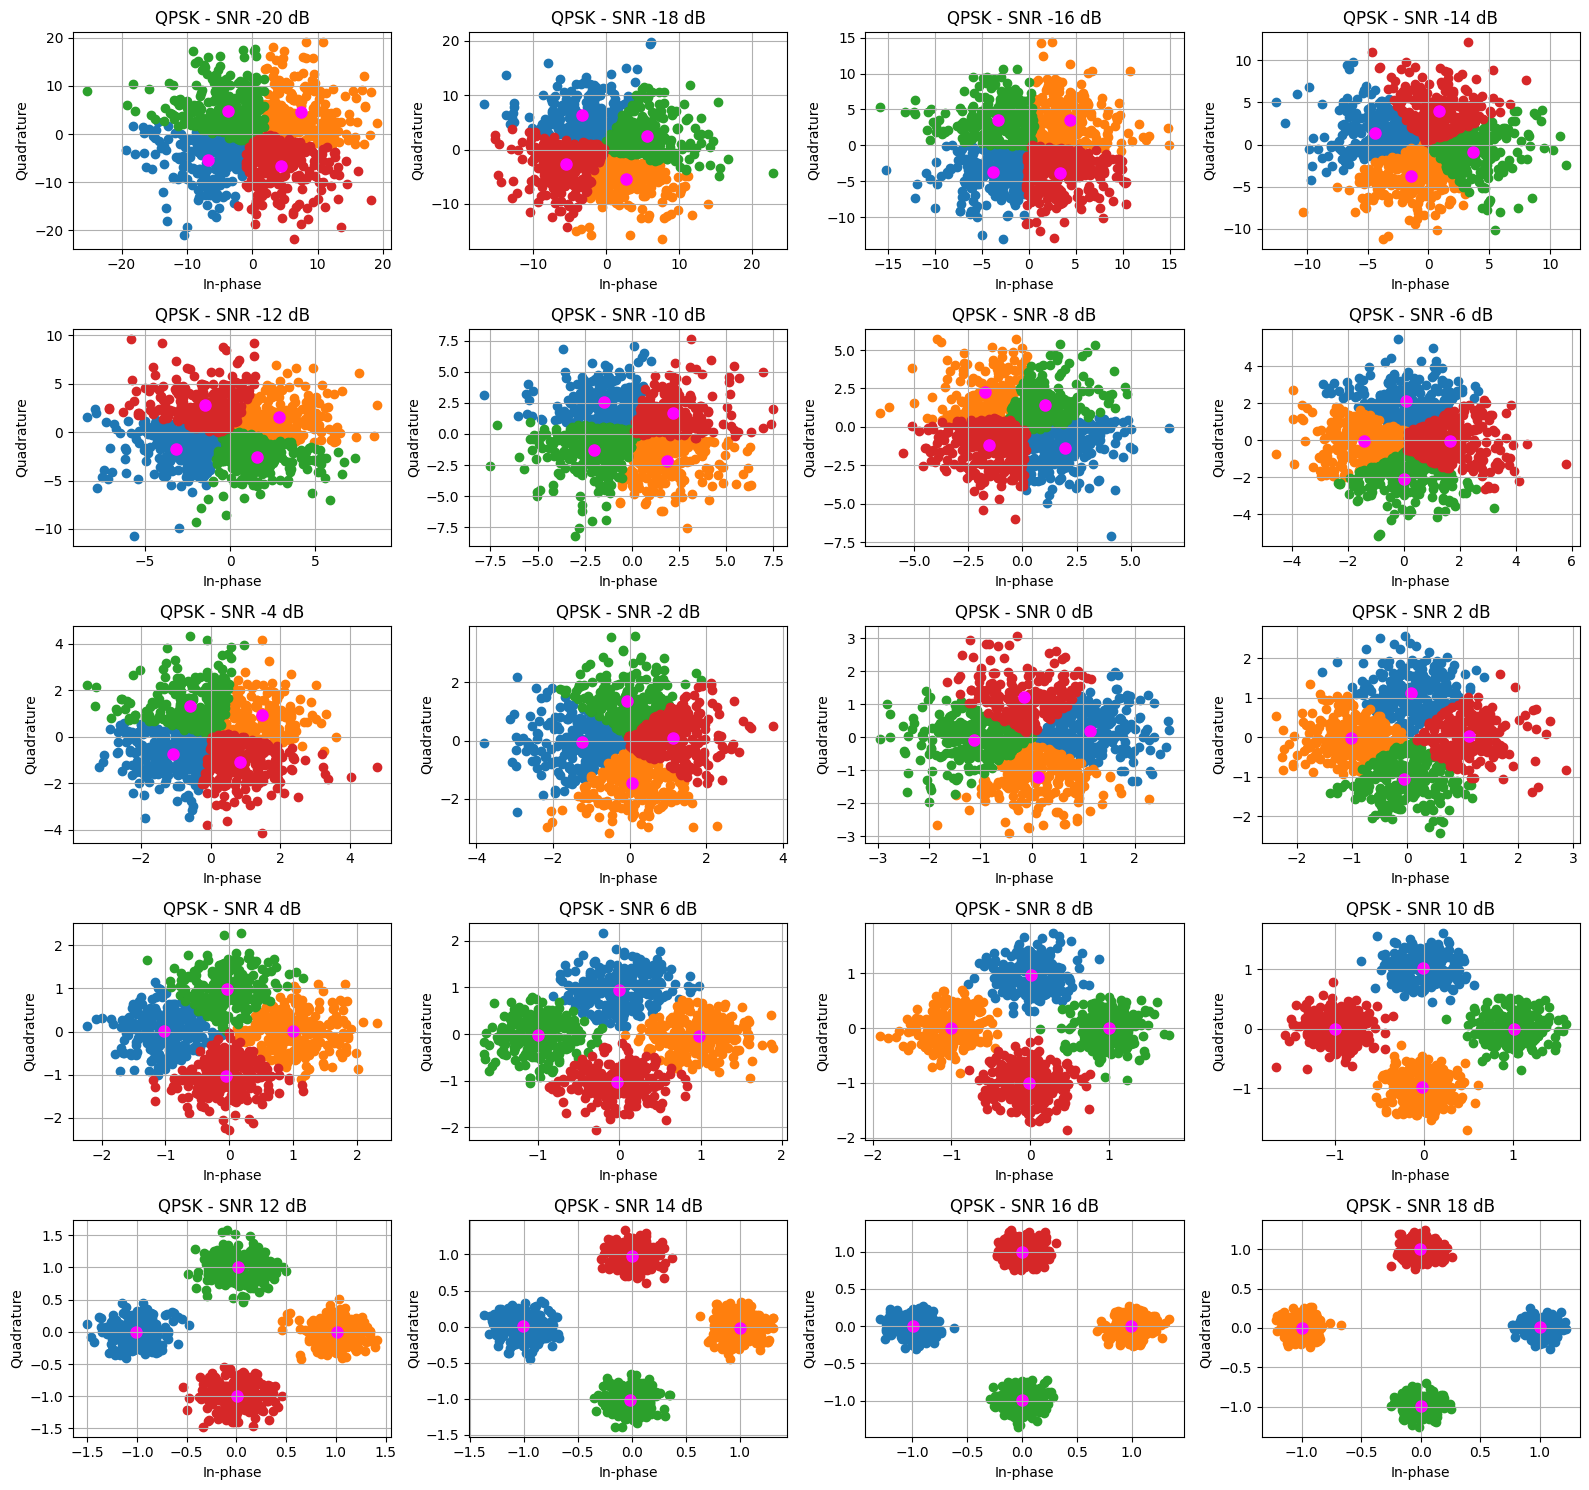

In [ ]:
mean_ratio, snr_values = quad('QPSK')
# mean_ratio2, snr_values2 = quad('QAM16')
# mean_ratio3, snr_values3 = quad('QAM64')

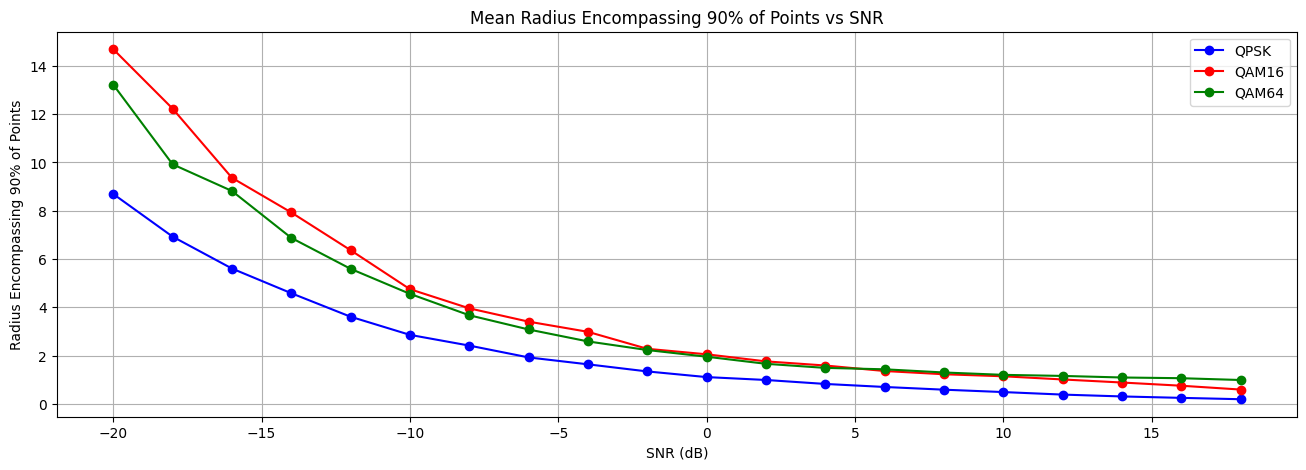

In [ ]:
# Plotting the radius against SNR values
plt.figure(figsize=(16,5))
plt.plot(snr_values, mean_ratio, marker='o', linestyle='-', color='b', label='QPSK')
plt.plot(snr_values2, mean_ratio2, marker='o', linestyle='-', color='r', label='QAM16')
plt.plot(snr_values3, mean_ratio3, marker='o', linestyle='-', color='g', label='QAM64')
plt.title(f'Mean Radius Encompassing 90% of Points vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel(f'Radius Encompassing 90% of Points')
plt.grid(True)
plt.legend()
plt.show()